# Repixel
## Convert a scaled jpeg of pixel art into pixel perfect bitmap


In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib import image as pltimg
from scipy.signal import find_peaks
from scipy.stats import describe
from scipy.optimize import linear_sum_assignment
from sklearn import cluster
from IPython import display
from glob import glob
import math

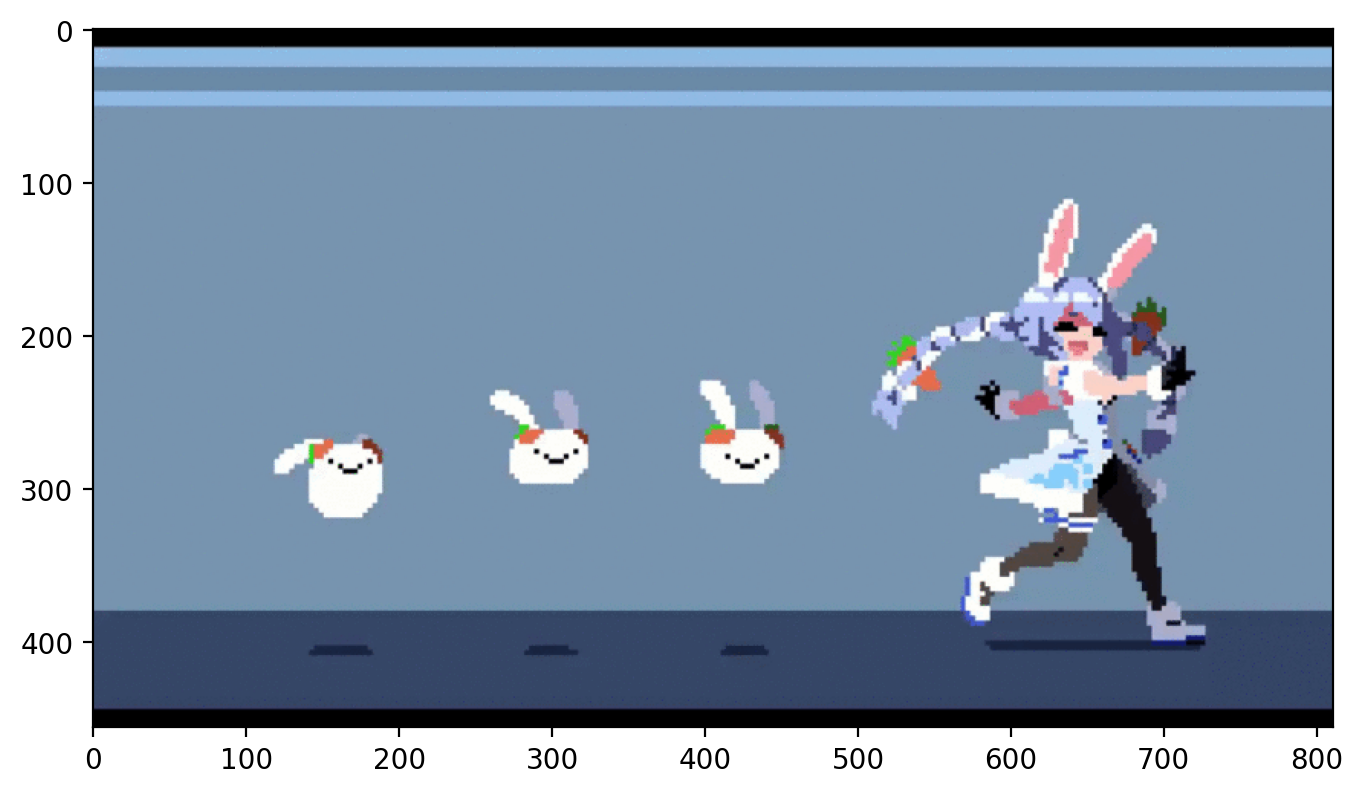

In [2]:
# read images from src
data = []
for f in glob("../input/frames/usada_pekora*.png"):
    data.append(np.array(pltimg.imread(f)))

plt.figure(figsize=(8,8), dpi=200)
plt.imshow(data[0])

In [3]:
# use Sobel to identify edges and highlight them

def sobel_edges(image, threshold=None, prominence=0.01):
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    x = cv.Sobel(gray, cv.CV_32F, 1, 0, ksize=3)
    y = cv.Sobel(gray, cv.CV_32F, 0, 1, ksize=3)

    sx = np.mean(np.abs(x), axis=(0))
    sy = np.mean(np.abs(y), axis=(1))

    px = find_peaks(sx, height=0, prominence=prominence, threshold=threshold)[0]
    py = find_peaks(sy, height=0, prominence=prominence, threshold=threshold)[0]

    return px, py

def plot_grid(image, x, y):
    plt.figure(figsize=(8,8), dpi=200)
    plt.imshow(image, cmap="gray")

    for p in x:
        plt.axvline(x=p, lw=0.5)

    for p in y:
        plt.axhline(y=p,lw=0.5)

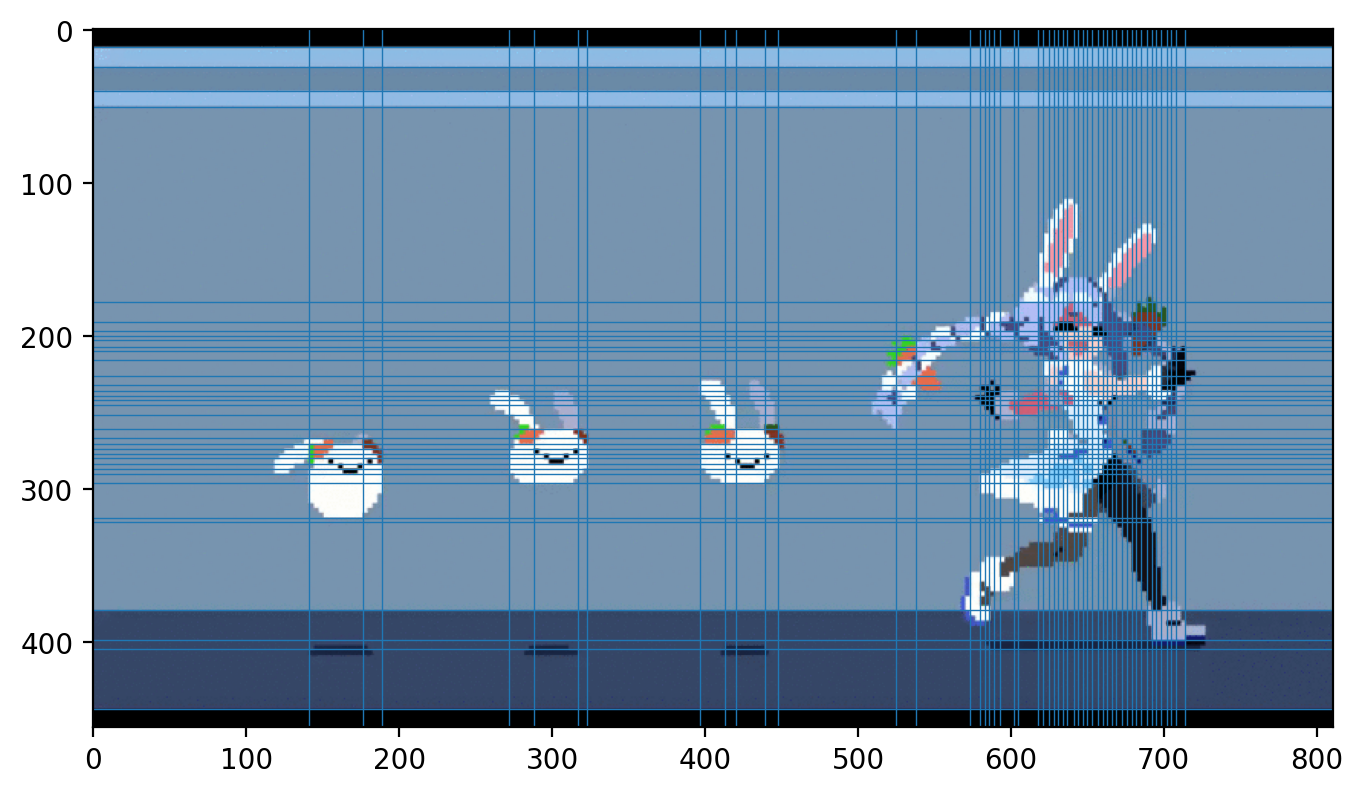

In [4]:
px, py = sobel_edges(data[0], threshold=None, prominence=0.05)
plot_grid(data[0], px, py)

find_freq:  range(94, 192)
find_freq:  range(71, 145)
3.201117318435754 3.2074074074074073


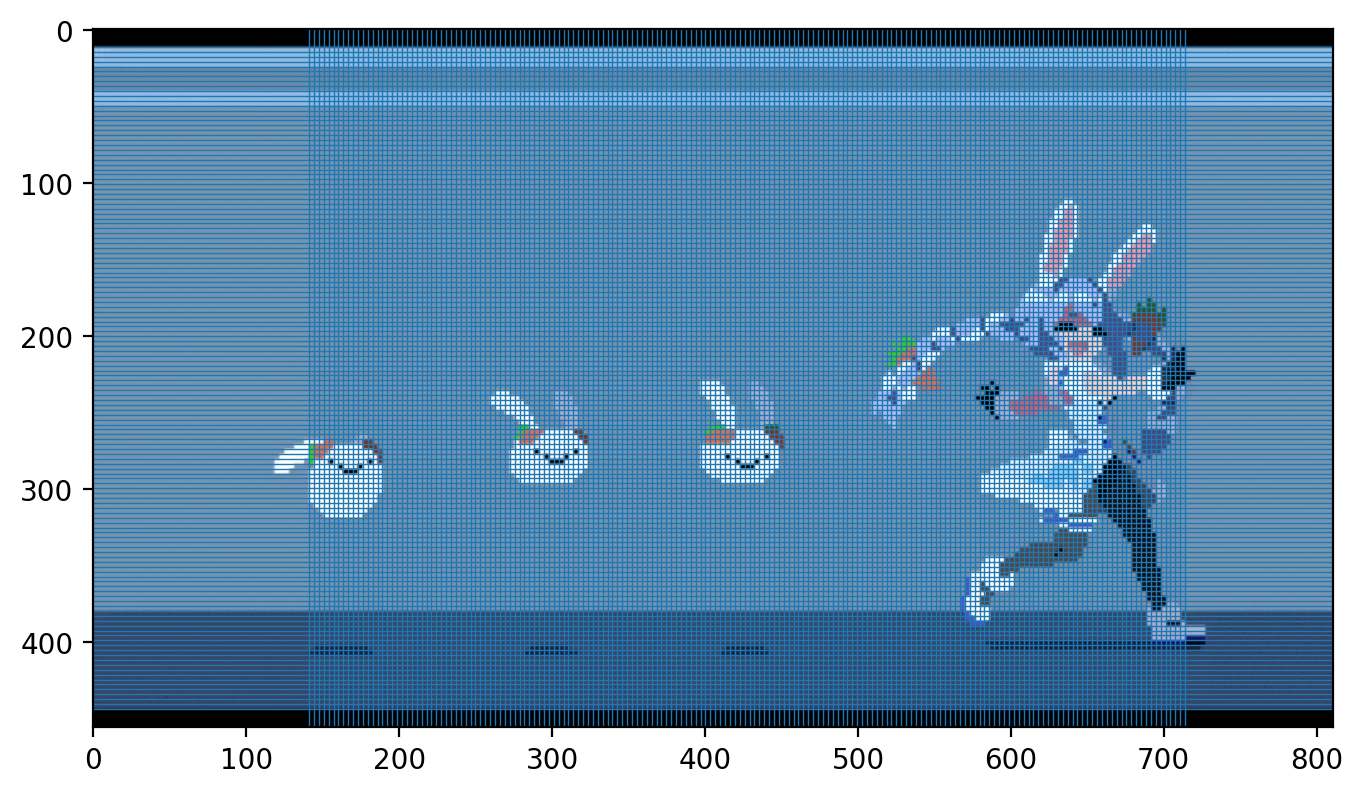

In [5]:
# Linear search for correct inner frequency

# Assumes there are no outliers
def find_freq(peaks, pixel_min = None, pixel_max = None):
    if not pixel_min:
        pixel_min = min(np.diff(peaks))
    if not pixel_max:
        pixel_max = pixel_min*2 #optimise this

    width = peaks[-1] - peaks[0]
    search_space = range(width//pixel_max-1, width//pixel_min+1)
    best_c = len(peaks)*peaks[-1]
    best_grid = 0
    print("find_freq: ", search_space)
    for total_pixels in search_space:
        grid = np.linspace(peaks[0], peaks[-1], num=total_pixels+1)
        cost = np.array([[abs(g-p) for g in grid] for p in peaks])
        rowi, coli = linear_sum_assignment(cost)
        c = cost[rowi, coli].sum()
        if c <= best_c:
            best_c = c
            best_grid = total_pixels
            # print("best: ", best_c, best_grid)
    
    return best_grid

x_num = find_freq(px)
y_num = find_freq(py)

x_grid, x_size = np.linspace(px[0], px[-1], num=x_num+1, retstep=True)
y_grid, y_size = np.linspace(py[0], py[-1], num=y_num+1, retstep=True)

print(x_size, y_size)

plot_grid(data[0], x_grid, y_grid)

find_freq:  range(94, 192)
find_freq:  range(71, 145)


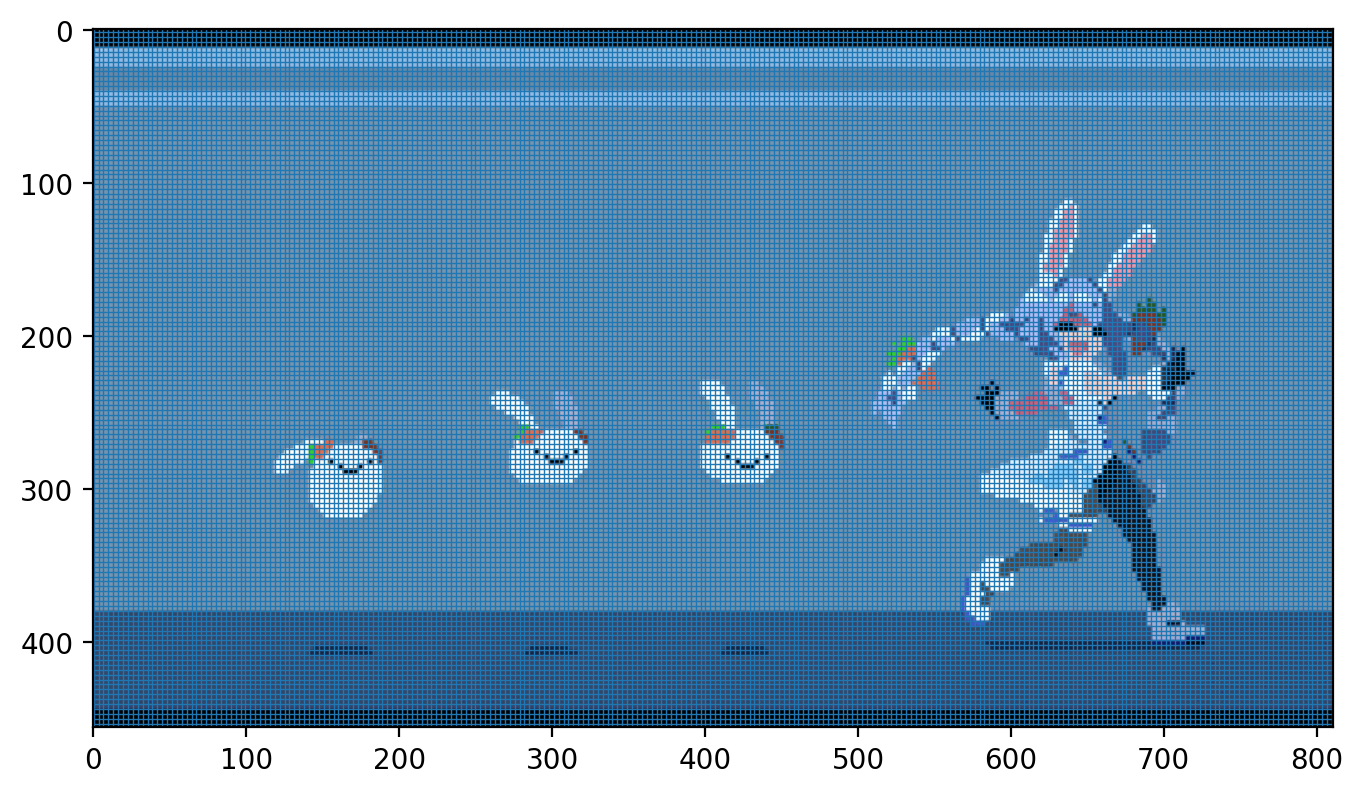

In [6]:
def produce_grid(image, prominence=0.01, threshold=None):
    height, width, _ = image.shape
    px, py = sobel_edges(image, prominence=prominence, threshold=threshold)
    x_num = find_freq(px)
    y_num = find_freq(py)

    x_grid, x_size = np.linspace(px[0], px[-1], num=x_num+1, retstep=True)
    y_grid, y_size = np.linspace(py[0], py[-1], num=y_num+1, retstep=True)

    x_full_grid = np.concatenate((np.arange(px[0], 0, -x_size)[::-1][:-1], x_grid, np.arange(px[-1], width, x_size)[1:]))
    y_full_grid = np.concatenate((np.arange(py[0], 0, -y_size)[::-1][:-1], y_grid, np.arange(py[-1], height, y_size)[1:]))

    return x_full_grid, y_full_grid

x_full_grid, y_full_grid = produce_grid(data[0], prominence=0.05)

plot_grid(data[0], x_full_grid, y_full_grid)

In [7]:
# Part 2: generate pixel art from grid information
def proportion_of_image(image, hmin, hmax, wmin, wmax, debug=False, depth=4):
    # TODO: Gaussian Kernel smoothing at (mean(hmax,hmin),mean(wmax,wmin)) 
    if debug:
        print(math.ceil(hmin),math.floor(hmax)+1,math.ceil(wmin),math.floor(wmax)+1)
    section = image[math.ceil(hmin):math.floor(hmax)+1,math.ceil(wmin):math.floor(wmax)+1]
    discrete_median = np.median(section.reshape((-1,depth)), axis=(0))
    # discrete_mean = np.median(section, axis=(0,1), dtype=np.float32)
    # discrete_mode = scipy.stats.mode(section.reshape((-1, 4)), axis=(0))
    return discrete_median

def generate_pixel(image, h, w):
    h_len = len(h)-1
    w_len = len(w)-1
    depth = image.shape[-1]
    print(w_len, h_len)
    res = np.zeros((h_len,w_len,depth), dtype=np.float32)
    
    for rh in range(h_len):
        for rw in range(w_len):
            res[rh][rw] = proportion_of_image(image, h[rh], h[rh+1], w[rw], w[rw+1], depth=depth)

    return res

(456, 811, 4)
253 141


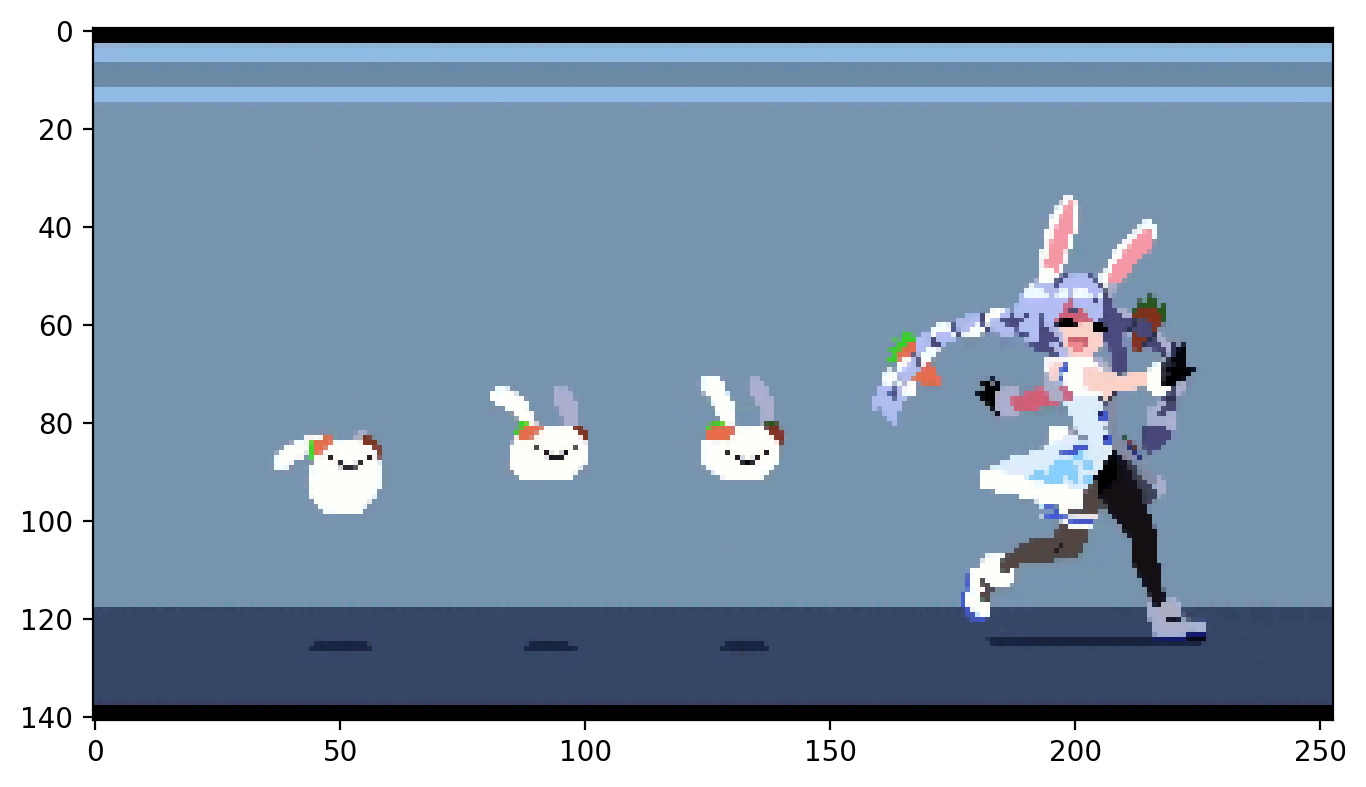

In [8]:
print(data[0].shape)
res = generate_pixel(data[0], y_full_grid, x_full_grid)
plt.figure(figsize=(8,8), dpi=200)
plt.imshow(res)